In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [3]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_BPHTB.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2012-1,6719300,2012-01-01
1,2012-2,7000000,2012-02-01
2,2012-3,59210200,2012-03-01
3,2012-4,6719300,2012-04-01
4,2012-5,9000000,2012-05-01


In [4]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/bphtb.json', 'w') as f:
    json.dump(json_data, f) 

{"2012-01-01T00:00:00.000":6719300,"2012-02-01T00:00:00.000":7000000,"2012-03-01T00:00:00.000":59210200,"2012-04-01T00:00:00.000":6719300,"2012-05-01T00:00:00.000":9000000,"2012-06-01T00:00:00.000":12125000,"2012-07-01T00:00:00.000":6719300,"2012-08-01T00:00:00.000":4675000,"2012-09-01T00:00:00.000":6325000,"2012-10-01T00:00:00.000":5746000,"2012-11-01T00:00:00.000":3830000,"2012-12-01T00:00:00.000":6501000,"2013-01-01T00:00:00.000":8512950,"2013-02-01T00:00:00.000":8797500,"2013-03-01T00:00:00.000":21135200,"2013-04-01T00:00:00.000":8512950,"2013-05-01T00:00:00.000":12621200,"2013-06-01T00:00:00.000":22000000,"2013-07-01T00:00:00.000":30023000,"2013-08-01T00:00:00.000":9500000,"2013-09-01T00:00:00.000":19003250,"2013-10-01T00:00:00.000":13725000,"2013-11-01T00:00:00.000":35211175,"2013-12-01T00:00:00.000":503542125,"2014-01-01T00:00:00.000":85150700,"2014-02-01T00:00:00.000":20289050,"2014-03-01T00:00:00.000":10708500,"2014-04-01T00:00:00.000":85150700,"2014-05-01T00:00:00.000":522225

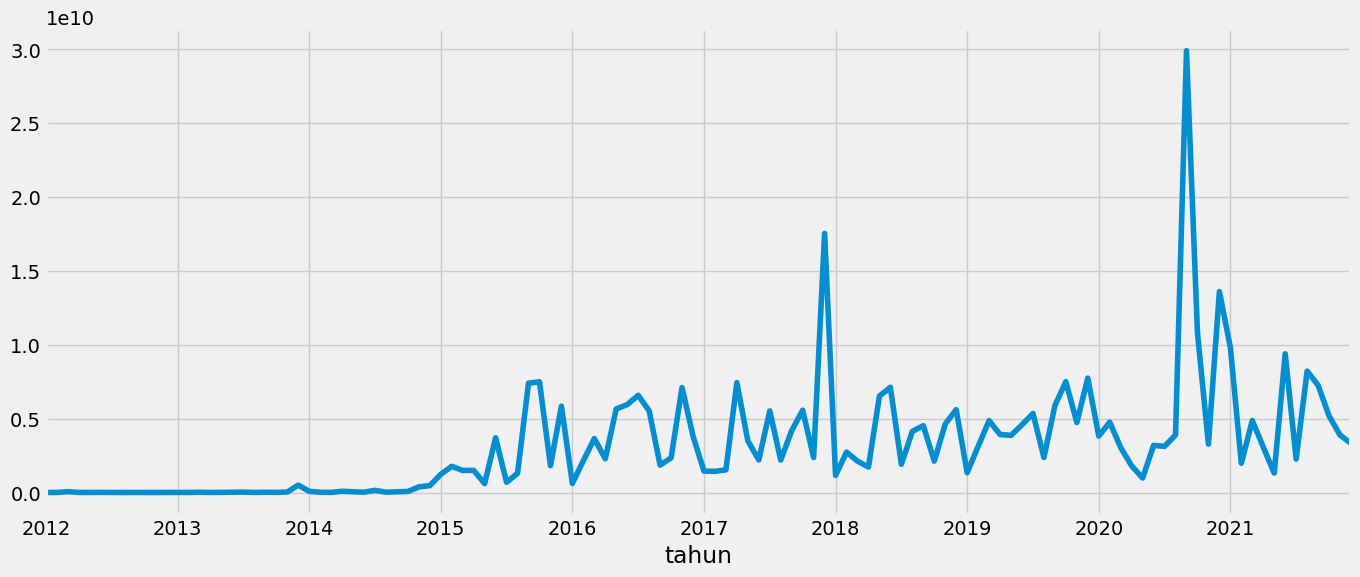

In [6]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [30]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [31]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(0, 1, 1), (1, 1, 1, 12), 5047.377377353612]


In [5]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 0, 0),seasonal_order=(1, 1, 1, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -2236.642
Date:                              Wed, 28 Dec 2022   AIC                           4481.284
Time:                                      07:33:37   BIC                           4491.499
Sample:                                  01-01-2012   HQIC                          4485.412
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2988      0.226      1.324      0.186      -0.144       0.741
ar.S.L12      -0.48

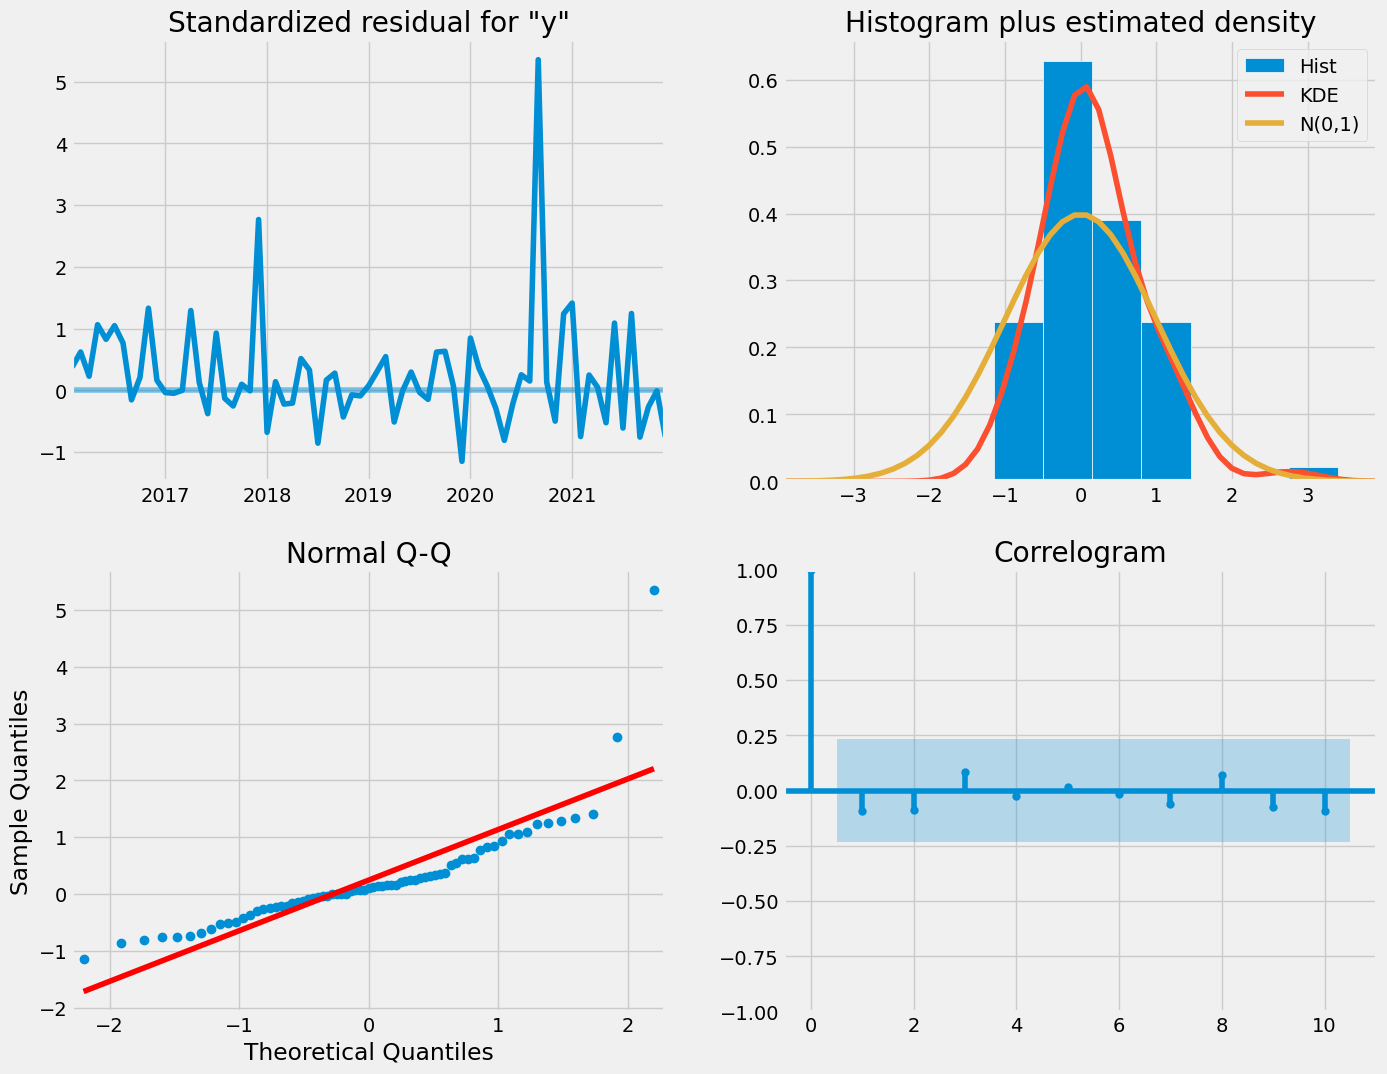

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

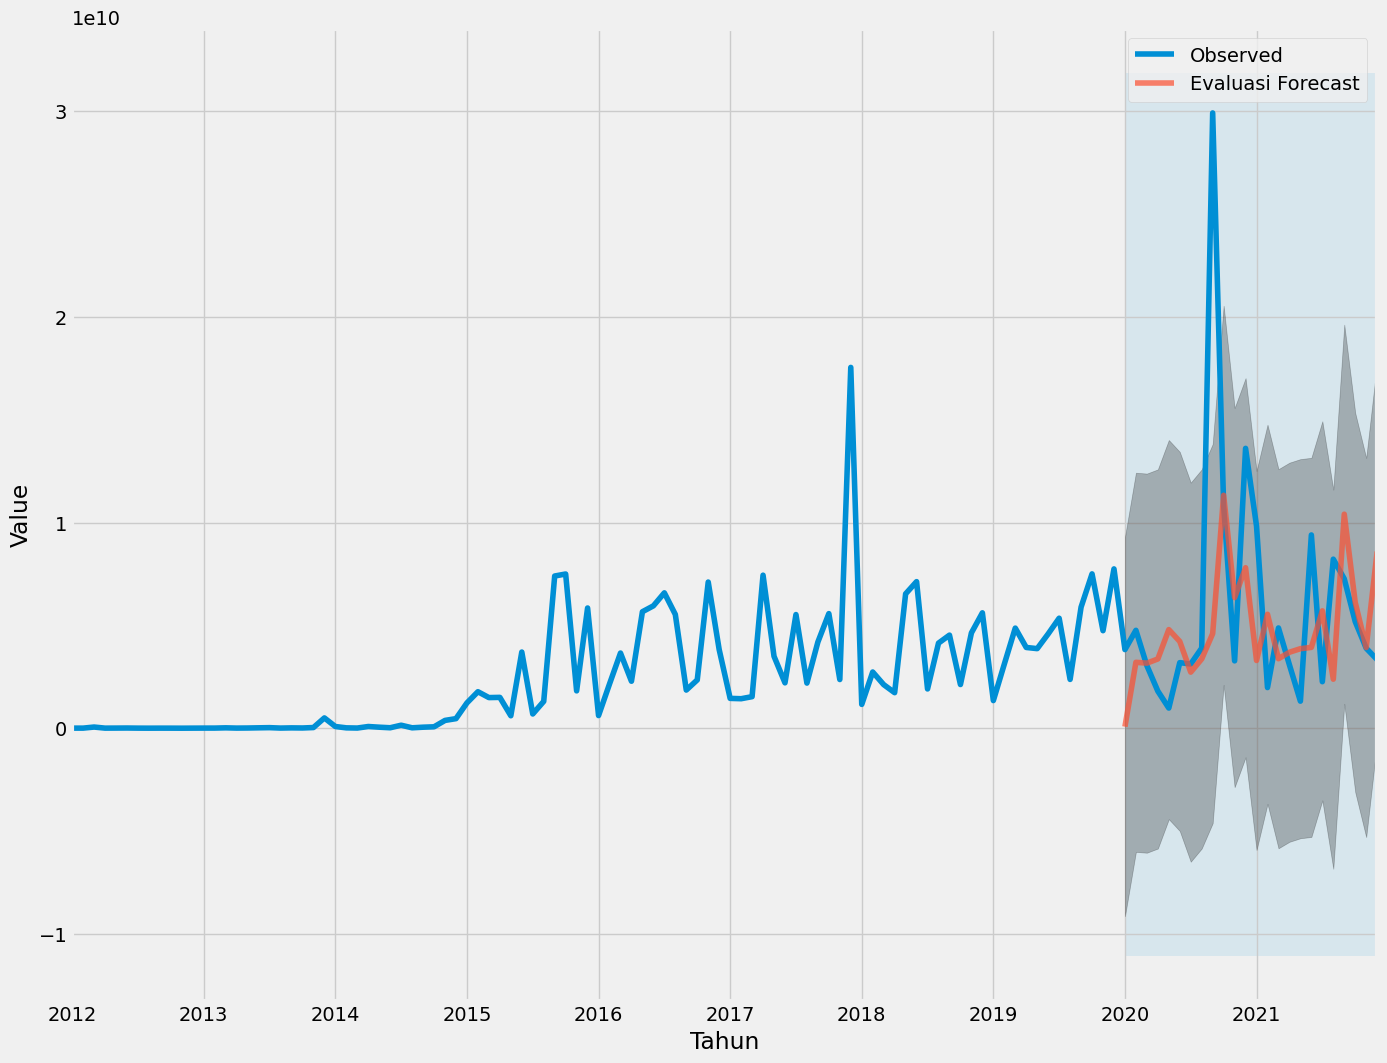

In [48]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [9]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()
json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/bphtb_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":2278680131.6936483383,"2022-02-01T00:00:00.000":3261152805.3714518547,"2022-03-01T00:00:00.000":3416303533.8728499413,"2022-04-01T00:00:00.000":2519767693.8090581894,"2022-05-01T00:00:00.000":2116331818.8280789852,"2022-06-01T00:00:00.000":4652476133.5065498352,"2022-07-01T00:00:00.000":3438933606.4155097008,"2022-08-01T00:00:00.000":4190594700.6018223763,"2022-09-01T00:00:00.000":18828154643.6681365967,"2022-10-01T00:00:00.000":8430607989.9805469513,"2022-11-01T00:00:00.000":3760926039.9050045013,"2022-12-01T00:00:00.000":10309969933.0353012085,"2023-01-01T00:00:00.000":6534033581.820400238,"2023-02-01T00:00:00.000":2817597269.8154211044,"2023-03-01T00:00:00.000":4177524386.0680890083,"2023-04-01T00:00:00.000":2807694202.1374969482,"2023-05-01T00:00:00.000":1734061869.5422003269,"2023-06-01T00:00:00.000":6953867180.9404468536,"2023-07-01T00:00:00.000":2870315806.2701568604,"2023-08-01T00:00:00.000":6143775224.6266069412,"2023-09-01T00:00:00.000":13223737105.

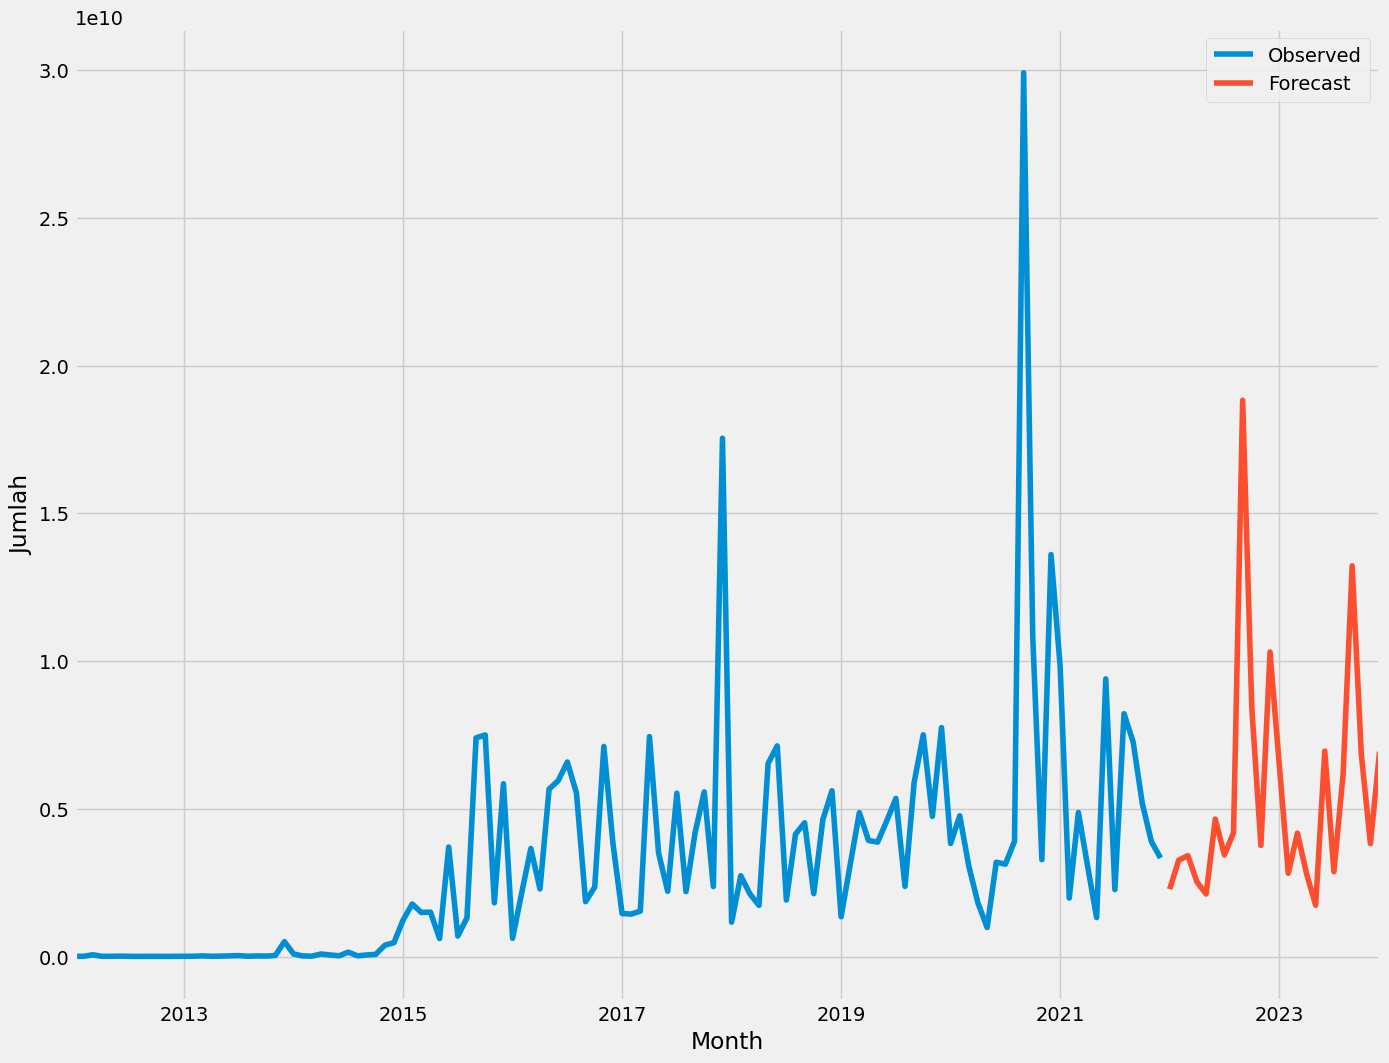

In [47]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()